# MATH 5472 Final Report: 
# Simulation of *Gaussian process based nonlinear latent structure discovery in multivariate spike train data* in Python

## Content
1. Introduction
    1. Overview of the paper
    1. Overview of my work
1. Implementation
    1. Full Aagorithm
    1. Rearrange of the formula containing $K_x^{-1}$
    1. Initialization value
    1. Code and Result
1. Discussion
    1. Singular $K_x$ and decaying noise variance $\sigma^2$ trick
    1. Renew of $l$ and $\rho$
    1. Performance and time consumption

The paper can be found in https://dl.acm.org/doi/abs/10.5555/3294996.3295108.(or in my Github link) The author's source code can be found in https://github.com/waq1129/LMT (written in MATLAB)

Github link: https://github.com/prulev/P-GPLVM-simulation-in-Python. Attached this report.ipynb file, dataset simdata1.mat, and related papers


## 1. Introduction

### 1.1. Overview of the paper

1.	Why is it interesting? 

Prof. Jose C. Principe has pointed out the difficulties of decoding information from the neural system, which is non-linear, dynamic, non-stationary, and non-ergodic. On top of this, it is hard to extract useful information from spike train data because they are high-dimensional and sparse. In recent years, decoding methods have improved to the point where most methods are accurate enough. Because of this, researchers are now focusing more on tackling the system’s challenging properties, such as its dynamic behavior.

The model and algorithm introduced in this paper differ from time-sequential models like the Kalman Filter. Instead of following a time-sequential approach, they aim to identify latent variables in a non-time-sequential manner. This non-time-sequential approach holds potential for addressing non-linear and dynamic problems in the future.

2.	What are the major challenges to solve?

The neural activities in some brain regions (e.g., hippocampal place cell) exhibit high linear dimensionality, however, we are interested in the discovery of low-dimensional non-linear latent structure from it. 

3.	How does the proposed method address the challenges? 

The authors proposed a new model (P-GPLVM), by adding the Poisson process for neuron spike firing and the decoupled Laplace approximation for training efficiency on the existing GPLVM models. And they show it outperforms existing methods in terms of both speed of convergence and accuracy.

### 1.2. Overview of my work

I replicated the key simulation work from this paper using Python. And I didn't use any of the author's original MATLAB code. However, my results are not as good as the author's, likely because my optimization process is less effective. As a result, my algorithm is slow and fails to converge.



## 2. Implementation

### 2.1. Full algorithm

The paper only shows the key part of the algorithm. (See Algorithm 1 on Page 6) The full algorithm should be:

**Poisson Gaussian Process Latent Variable Model**

At iteration $k$ 
(Input: data observation $y_i$, latent variable $X$ from iteration $k-1$; superscript $k$ indicating iteration is omitted): 

1. Renew $\hat{f}_i$ (as static values independent of $X$)
    1. Compute $K_x$ using $X$ from last iteration
    1. Compute the new $\hat{f}_i$ and $A_i$ by solving (with the assumption of that Poisson observations at different time are independent )
    $$\hat{f}_i \leftarrow \arg \max_{f_i} \Psi(f_i) = \log p(y_i|f_i) + \log p(f_i|X) 
    = y_i^Tf_i - \sum_t \exp(f_{i,t}) - {1 \over 2} f_i^T K_x ^{-1} f_i + const$$
    $$ A_i \leftarrow W_i + K_x ^{-1} = diag(\exp(f_{i,1}), ... ,\exp(f_{i,t}), ... ,\exp(f_{i,T})) + K_x ^{-1}$$

1. Renew $X$
    1. Compute $K_x(X)$ using $X$ from last iteration as functions of $X$, in which $X$ will be optimized later
    1. Compute the new $\hat{f}_i(X)$ as functions of $X$
        1. $ S_i = (A_i - K_x^{-1} )^{-1}, m_i = S_i A_i \hat{f}_i $
        1. $ A_i(X) = S_i^{-1} + K_x(X)^{-1} = (A_i - K_x^{-1} )+ K_x(X)^{-1} = (W_i + K_x ^{-1} - K_x^{-1} )+ K_x(X)^{-1} = W_i+ K_x(X)^{-1}$
        1. What we need to compute is: 
        $$ \hat{f}_i(X) \leftarrow A_i(X)^{-1} A_i \hat{f}_i  = (W_i+ K_x(X)^{-1})^{-1} A_i \hat{f}_i$$
    1. Compute $$\log q(y_i|X) \leftarrow y_i^T\hat{f}_i(X) - \sum_t \exp(\hat{f}_i(X)) - {1 \over 2} \hat{f}_i(X)^T K_x(X)^{-1} \hat{f}_i(X) -{1 \over 2} \log |I_T + K_x(X) W_i| + const$$
        $$ \log p(X) = - {1 \over 2} X^T K_t^{-1}X + const$$
    1. Renew $X$ by $$ X \leftarrow \arg \max_{X} MAP(X) := \sum_i \log q(y_i|X) + N \log p(X) $$
    (There is a typo in Equation 14 and Algorithm 1 Step 5, MAP should be the summation of logarithms, according to the author)

1. Renew kernel coefficients $\rho_{fx}, l_{fx}, \rho_{xt}, l_{xt} $
    1. $$ \rho_{fx}, l_{fx}  \leftarrow \arg \max_{\rho_{fx}, l_{fx}} \log p(f|X,\rho_{fx}, l_{fx})$$
    1. $$ \rho_{xt}, l_{xt}  \leftarrow \arg \max_{\rho_{xt}, l_{xt}} \log p(X|\rho_{xt}, l_{xt})$$



### 2.2. Initialization value

The EM algorithm is sensitive to the initial values of the parameters, so choose initial values must be careful.

#### $f$ initialization

$f$ is initialized by $\sqrt{Y}$ pointwisely.

#### $X$ initialization

In the original work, $X$ is initialized by Poisson Linear Dynamics System (PLDS) that appears in *Inference and Decoding of Motor Cortex Low-Dimensional Dynamics via Latent State-Space Models* Page 274 (can be found in my Github link). But implementing this method without previous packages in Python requires too much background knowledge and time.

So in my work, I used Probabilistic Principal Component Analysis (PPCA) from *Probabilistic Principal Component Analysis* (also can be found in my Github link). This method basically did a PCA on $Y$ and applied a shrinkage on the eigenvalues according to the dimension.


### 2.3. Rearrange of the formula containing $K_x^{-1}(X)$

$K_x(X)^{-1}$ is very easy to be singular (which will be discussed in Discussion), so it's necessary to avoid $K_x(X)^{-1}$ appear explicitly.

1. Rewrite $ \hat{f}_i(X) \leftarrow (W_i+ K_x(X)^{-1})^{-1} A_i \hat{f}_i$ as:
    $$ \hat{f}_i(X) \leftarrow (I_T + K_x(X)W_i)^{-1} K_x(X) A_i \hat{f}_i $$

1. Rewrite $ \hat{f}_i(X)^T K_x(X)^{-1} \hat{f}_i(X) $.
    According to the property of Gaussian Process, for the Gaussian Process $x \rightarrow f(x)$ with covariance matrix $K_x$, if we do eigenvalue decomposition $K_x = Q\Lambda Q^T$, then $u = \Lambda^{-1/2} Q^T f$ is an independent multivariable $N(0,1)$ distribution, s.t., $f^T K_x^{-1} f = f^TQ\Lambda^{-1} Q^T f = (\Lambda^{-1/2} Q^T f)^T \Lambda^{-1/2} Q^T f = u^Tu$. 
    
    Here we first do eigenvalue decomposition $K_x(X) = Q(X) \Lambda(X) Q(X)^T$, then can calculate $U_i(X)$, and substitute $ \hat{f}_i(X)^T K_x(X)^{-1} \hat{f}_i(X) $ by $U_i(X)^T U_i(X)$. 

    And my aim is, no explicit $K_x(X)^{-1}$ or $\Lambda(X)^{-1}$ appear in the $U_i(X)$ formula.

    With matrix inverse lemma: $ (A+BCD)^{-1} = A^{-1} - A^{-1}B (C^{-1} + DA^{-1}B)^{-1} DA^{-1}$

    $$\begin{align*} U_i(X) &= \Lambda(X)^{-1/2} Q(X)^T \hat{f}_i(X)\\
    &= \Lambda(X)^{-1/2} Q(X)^T (W_i+ K_x(X)^{-1})^{-1} \ A_i \hat{f}_i\\
    ^{lemma} &= \Lambda(X)^{-1/2} Q(X)^T [K_x(X) - K_x(X)[ W_i^{-1} + K_x(X)]^{-1} K_x(X)] \ A_i \hat{f}_i\\
    &= [\Lambda(X)^{1/2} Q(X)^T  - \Lambda(X)^{1/2} Q(X)^T [ W_i^{-1} + K_x(X)]^{-1} K_x(X)] \ A_i \hat{f}_i\\
    &= [\Lambda(X)^{1/2} Q(X)^T  - \Lambda(X)^{1/2} [ Q(X)^T W_i^{-1}Q(X) + \Lambda(X)]^{-1} \Lambda(X)Q(X)^T] \ A_i \hat{f}_i\\
    &= [I_T  - \Lambda(X)^{1/2} [ Q(X)^T W_i^{-1}Q(X) + \Lambda(X)]^{-1} \Lambda(X)^{1/2}] \ \Lambda(X)^{1/2} Q(X)^T  \ A_i \hat{f}_i\\
    &= [I_T  - [ \Lambda(X)^{1/2}Q(X)^T W_i^{-1}Q(X)\Lambda(X)^{1/2}  + I_T ]^{-1} ]\ \Lambda(X)^{1/2} Q(X)^T  \ A_i \hat{f}_i\\
    ^{lemma} &= [I_T  + \Lambda(X)^{1/2}Q(X)^T  \ W_i \ Q(X)\Lambda(X)^{1/2}  ]^{-1} \ \Lambda(X)^{1/2} Q(X)^T  \ A_i \hat{f}_i\\
    \end{align*}$$

    Then we don't need to be worry about $K_x(X)^{-1}$ to be singular.

In 3.1. Singular $K_x$ and decaying noise variance $\sigma^2$ trick, there is another important method that can avoid $K_x(X)^{-1}$, but my method still should have some advantagement, see 3.1.

### 2.4. Code and Result

In [1]:
import numpy as np
from numpy import linalg as LA
import scipy.io as sio
import matplotlib.pyplot as plt
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas

import torch as th

from scipy.optimize import fsolve
from scipy.optimize import minimize
from scipy.optimize import leastsq

from plot_functions import *

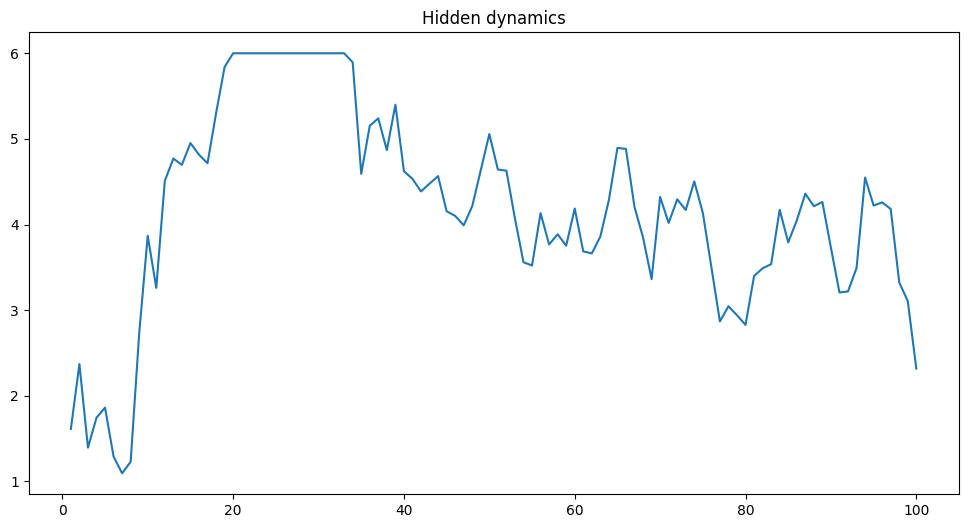

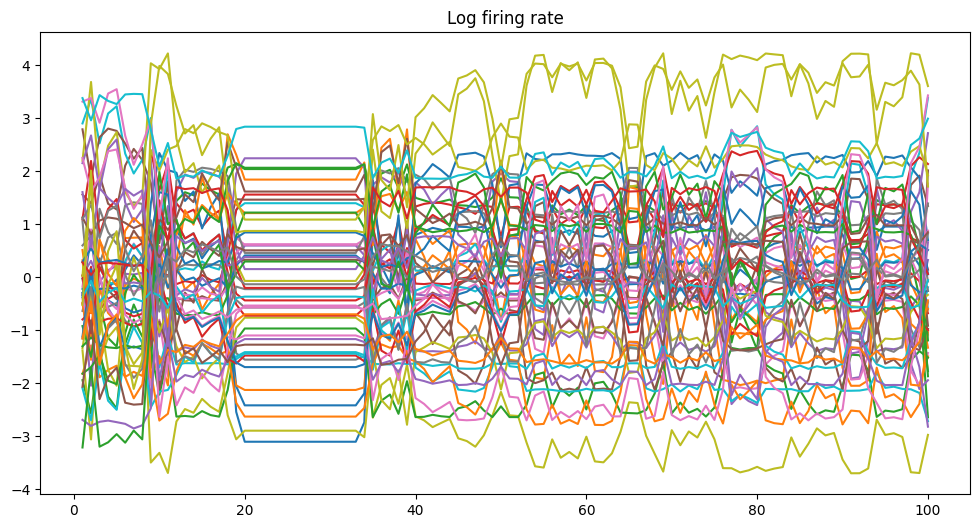

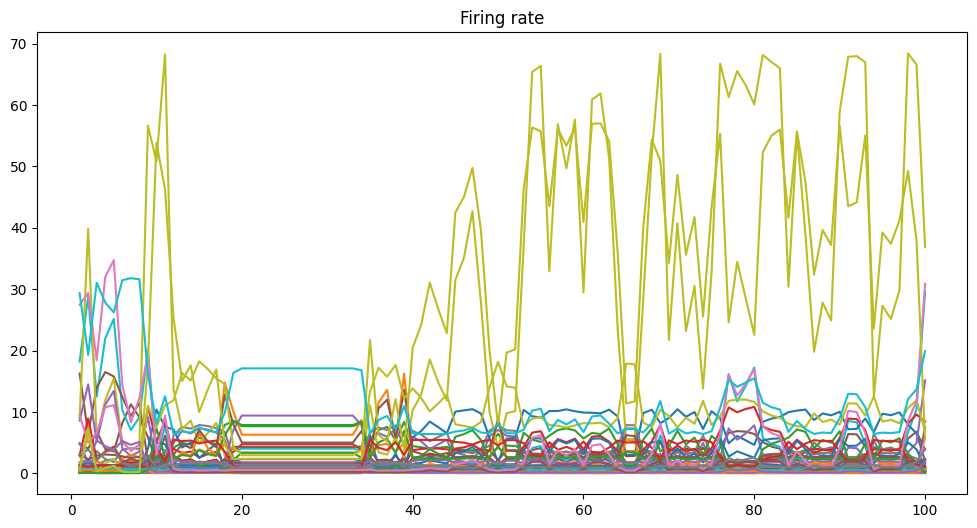

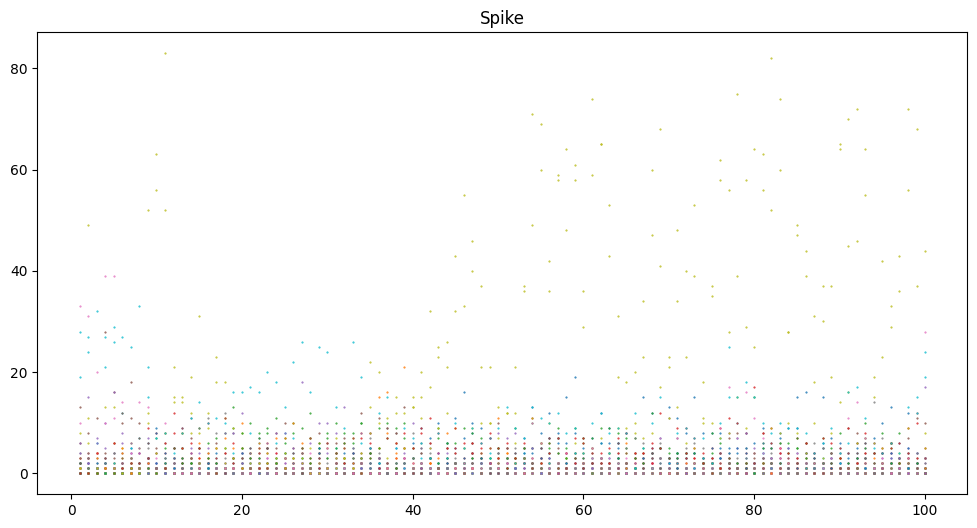

In [2]:
# import the Simulation data from the author

simdata1 = sio.loadmat('simdata1.mat')
simdata = simdata1['simdata'][0][0]
latentVariable = simdata['latentVariable']
spikes = simdata['spikes']
spikeRates = simdata['spikeRates']
tuningCurve = simdata['tuningCurve'] 
xgrid = simdata['xgrid'] 
tgrid = simdata['tgrid']

# choose first 100 time points 
T = 100
time = tgrid[:T,0]
X_truth = np.transpose(latentVariable[:T])
Y = np.transpose(spikes[:T])
Y_line = Y.reshape(-1)
fr_truth = np.transpose(spikeRates[:T])
f_wrt_X_truth = tuningCurve
f_truth = np.log(fr_truth)
plot_hidden(time, X_truth)
plot_log_fr(time, f_truth)
plot_fr(time, fr_truth)
plot_spk(time, Y)

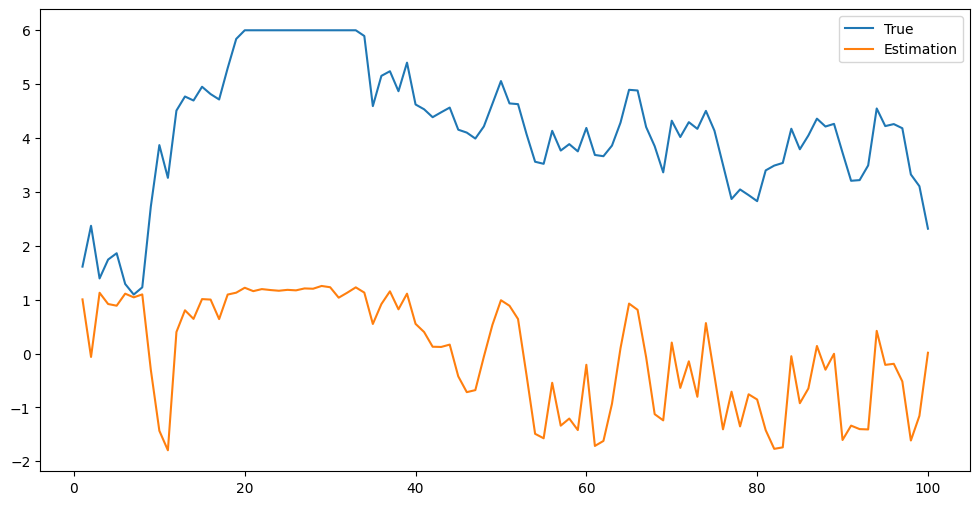

In [3]:
# Initial Data Generation
def PPCA(Y,q):
    d = Y.shape[0]
    # q = X_truth.shape[0]
    # print(d,q)
    Y_0_mean = Y - np.mean(Y, axis = 1).reshape(-1,1)
    S = 0
    for i in range(Y.shape[1]):
        S += np.outer(Y_0_mean[:,i], Y_0_mean[:,i])
    S = S / Y.shape[1]
    # S.shape
    eigenvalues_S, eigenvectors_S = LA.eig(S)
    PPCA_sig2 = np.sum(eigenvalues_S[q:]) / (d - q)
    W = eigenvectors_S[:,:q] * np.sqrt(eigenvalues_S[:q] - PPCA_sig2 * np.eye(q))
    # W.shape
    M = np.dot(W.T, W) + PPCA_sig2 * np.eye(q)
    X_ppca = LA.inv(M).dot(np.dot(W.T, Y_0_mean))
    return X_ppca, W, PPCA_sig2
X_ppca, _, _ = PPCA(Y, 1)
plot_hidden_estimation(time, X_truth, X_ppca, x_lim = None, y_lim = None)

In [13]:
# define functions for optimization
def K_static(time_index, rho, l2 ):
    Kt = np.zeros((T,T))
    for i in range(T):
        for j in range(T):
            Kt[i,j] = rho * np.exp( -np.linalg.norm( time_index[:,i] - time_index[:,j])**2 / (2 * l2) )
    return np.double(Kt)

def chi_f(f):
    effy = np.dot(Y_line, f) - np.sum(np.exp(f))
    fKf = 0
    for i in range(N):
        fKf += np.dot(f[i*T:(i+1)*T], np.dot(Kx_inv, f[i*T:(i+1)*T]))
    return - ( effy - 0.5 * fKf )

# dimensions
N = Y.shape[0]
T = Y.shape[1]
P = 1

In [30]:
# define the MAP class for X optimization, and the ML class for l2 optimization
class MAP(th.nn.Module):
    def __init__(self, X,Y,f_static, W_static, A_static, rho_f, l2_f, rho_xt, l2_xt, sigma2, add_sigma):
        super().__init__()
        self.X = th.nn.Parameter(th.tensor(X).double().detach())
        self.Y = th.tensor(Y)
        self.time_index = th.arange(0, T, 1).double()
        self.f_static = th.tensor(f_static).double() 
        self.W_static = th.tensor(W_static).double() 
        self.A_static = th.tensor(A_static).double() 
        self.rho_f = rho_f
        self.l2_f = l2_f
        self.rho_xt = rho_xt
        self.l2_xt = l2_xt
        self.sigma2 = sigma2
        self.add_sigma = add_sigma

    def K(self, time_index, rho, l2):
        Kt = th.zeros(T,T)
        for i in range(T):
            for j in range(T):
                Kt[i,j] = rho * th.exp( -th.norm( time_index[:,i] - time_index[:,j])**2 / (2 * l2) )
        return Kt
    
    def forward(self):
        Kx = self.K(self.X, self.rho_f, self.l2_f).double() 
        if self.add_sigma:
            Kx = Kx + self.sigma2 * th.eye(T)
        fx = th.zeros(N,T)
        for i in range(N):
            fx[i] = th.linalg.inv( th.eye(T) + Kx @ self.W_static[i]) @ Kx @ self.A_static[i] @ self.f_static[i]
        Lx, Qx = th.linalg.eig(Kx)
        # Lx = Lx.real
        # Qx = Qx.real
        sqrtKx = Qx @ th.diag( th.sqrt(Lx))
        Ux = th.zeros(N,T)
        for i in range(N):
            Ux[i] = th.linalg.inv( th.eye(T) + sqrtKx.t().real @ self.W_static[i] @ sqrtKx.real ) @ sqrtKx.t().real @ self.A_static[i] @ self.f_static[i]

        fx_flat = fx.reshape(-1)
        Y_flat = self.Y.reshape(-1)
        effy = th.sum( -th.exp(fx_flat) + fx_flat*Y_flat)
        UU = -0.5* th.norm(Ux, 'fro')**2        # don't forget **2 !!!
        logdet = 0
        for i in range(N):
            logdet = logdet -0.5* th.log( th.det( th.eye(T) + Kx @ self.W_static[i]))

        Kt = self.K(self.time_index.reshape(1,-1), self.rho_xt, self.l2_xt).double()
        xKx = -0.5* N * self.X.reshape(1,-1) @ th.linalg.inv(Kt) @ self.X.reshape(-1,1)     #only for dim X=1

        map_value = effy + UU + logdet + xKx
        return map_value, effy, UU, logdet, xKx, Kx, Lx, Qx, fx, Ux, sqrtKx

class ML_l2(th.nn.Module):
    def __init__(self, X, l20, time_index = None, sigma2 = None):
        super(ML_l2, self).__init__()
        self.X = th.tensor(X).detach().double()
        self.N = X.shape[0]
        self.T = X.shape[1]
        if time_index is not None:
            self.time_index = th.tensor(time_index).reshape(-1)
        else:
            self.time_index = th.tensor(np.arange(0.0, self.T, 1.0)).reshape(-1)
        self.rho = 1.0
        self.l2 = th.nn.Parameter(th.tensor(l20))
        self.sigma2 = sigma2

    def forward(self):
        Kt_rho1 = th.zeros(self.T, self.T).double()
        for i in range(self.T):
            for j in range(self.T):
                Kt_rho1[i,j] =  th.exp(-th.norm(self.time_index[i] - self.time_index[j])**2 / (2 * self.l2))
        non_inv=0
        if th.det(Kt_rho1) == 0:
            non_inv = 1
        if self.sigma2 is not None:
            Kt_rho1 = Kt_rho1 + self.sigma2 * th.eye(self.T)
        
        logdet = -0.5 * th.log(th.det(Kt_rho1))
        xKx = th.trace(self.X @ th.inverse(Kt_rho1) @ self.X.t())
        self.rho = xKx/self.T
        logxKx = -0.5 * self.T * th.log(xKx)

        log_p = logxKx + logdet
        return non_inv, log_p, logxKx, logdet, Kt_rho1, self.l2, self.rho

In [ ]:
# main loop

n_big_iter = 5
n_map_iter = 50
n_ml_iter = 10

is_debug_f = False
add_sigma = False

rho_f, l2_f, rho_xt, l2_xt, sigma2 = 1.0, 1.0**2, 1.0, 1.0**2, 2.0

X_ppca, _, _ = PPCA(Y, P)
# X_est = X_truth.copy()
X_est = X_ppca

f_initial = np.sqrt(Y)  # initial guess of the log firing rate
# f_initial_0_mean = f_initial - np.mean(f_initial, axis = 1).reshape(-1,1)
f_static = f_initial

f_big_iter = []
X_big_iter = []

for big_iter in range( n_big_iter ):

    sigma2 = sigma2 * 0.8
    Kx = K_static(X_est, l2_f, rho_f)
    Kx = Kx + sigma2* np.eye(T)
    Kx = np.double(Kx)
    print("detKx: ",np.linalg.det(Kx))
    Kx_inv = LA.inv(Kx)

    # solving f
    if not is_debug_f:
        f_est = f_static.reshape(-1)
        f_est = minimize(chi_f, f_est ,method='Powell', options={'xtol': 1e-8, 'disp': True}).x
        f_static = f_est.reshape(N,T)

    W_static = np.zeros((N,T,T))
    A_static = np.zeros((N,T,T))
    for i in range(N):
        W_static[i] = np.diag(np.exp( f_static[i] ))
        A_static[i] = W_static[i] + Kx_inv

    # MAP to estimate X
    map = MAP(X_est,Y, f_static, W_static, A_static, rho_f, l2_f, rho_xt, l2_xt, sigma2, add_sigma).double()
    optimizer = th.optim.Adam(map.parameters(), lr=0.05)
    scheduler = th.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.8)

    print("iter:",big_iter," map_iter:")
    for map_iter in range( n_map_iter ):
        map_value, effy, UU, logdet, xKx, Kx, Lx, Qx, fx, Ux, sqrtKx = map()
        loss = -1 * map_value
        optimizer.zero_grad()
        loss.backward()
        # th.nn.utils.clip_grad_norm_(map.parameters(), max_norm=1.)  # important! otherwise nan
        optimizer.step()
        scheduler.step()
        if map_iter ==0 or (map_iter +1 ) % 5 == 0:
            print(map_iter, loss.item(), map_value.item(), effy.item(), UU.item(), logdet.item(), xKx.item())

    f_static = fx.detach().numpy()
    X_est = map.X.detach().numpy()
    f_big_iter.append(f_static)
    X_big_iter.append(X_est)

    # ML to estimate l2 and rho for Xt
    ml = ML_l2(X_est, l20 = l2_xt, time_index = np.double(time), sigma2 = None).double()
    optimizer = th.optim.Adam(ml.parameters(), lr=0.05)
    scheduler = th.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.8)
    print("iter:",big_iter," l_rho_xt_iter:")
    for ml_iter in range( n_ml_iter ):
        non_inv, log_p, logxKx, logdet, Kt_rho1, l2, rho = ml()
        loss = -1 * log_p
        optimizer.zero_grad()
        loss.backward()
        # th.nn.utils.clip_grad_norm_(ml.parameters(), max_norm=1.)  # important! otherwise nan
        optimizer.step()
        scheduler.step()
        if ml_iter ==0 or (ml_iter +1 ) % 5 == 0:
            print(ml_iter, loss.item(), log_p.item(), logxKx.item(), logdet.item(), l2.item(), rho.item())
    l2_xt = l2.item()
    rho_xt = rho.item()

    # ML to estimate l2 and rho for fX
    ml = ML_l2(f_static, l20 = l2_f, time_index = X_est.reshape(-1), sigma2 = sigma2).double()
    optimizer = th.optim.Adam(ml.parameters(), lr=0.05)
    scheduler = th.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.8)
    print("iter:",big_iter," l_rho_f_iter:")
    for ml_iter in range( n_ml_iter ):
        non_inv, log_p, logxKx, logdet, Kt_rho1, l2, rho = ml()
        loss = -1 * log_p
        optimizer.zero_grad()
        loss.backward()
        # th.nn.utils.clip_grad_norm_(ml.parameters(), max_norm=1.)  # important! otherwise nan
        optimizer.step()
        scheduler.step()
        if ml_iter ==0 or (ml_iter +1 ) % 5 == 0:
            print(ml_iter, loss.item(), log_p.item(), logxKx.item(), logdet.item(), l2.item(), rho.item())
    l2_f = l2.item()
    rho_f = rho.item()

detKx:  3.116124322444231e+24


c:\Users\Lenovo\anaconda3\envs\PW\Lib\site-packages\numpy\_core\fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


Optimization terminated successfully.
         Current function value: -20651.836774
         Iterations: 1
         Function evaluations: 73280
iter: 0  map_iter:
0 -13751.404139742193 13751.404139742193 17158.61328125 -142.4442901611328 -336.47383713625385 -2928.2919449965516
4 -15291.548579018214 15291.548579018214 17370.806640625 -147.9106903076172 -342.927572080558 -1588.4203332762306
9 -15903.315487993104 15903.315487993104 17594.68359375 -163.1797332763672 -345.2160483030858 -1182.97236995381
14 -16273.322559471491 16273.322559471491 17904.138671875 -212.8623046875 -343.0700075563013 -1074.884776722209
19 -16522.52526543862 16522.52526543862 18129.84765625 -251.45321655273438 -339.59492579950796 -1016.2743400118723
24 -16680.828465019407 16680.828465019407 18273.765625 -271.79681396484375 -336.12647383325384 -985.0138111473397
29 -16782.443200772665 16782.443200772665 18372.986328125 -283.021240234375 -332.98735014209814 -974.5342928352366
34 -16843.257277144734 16843.2572771447

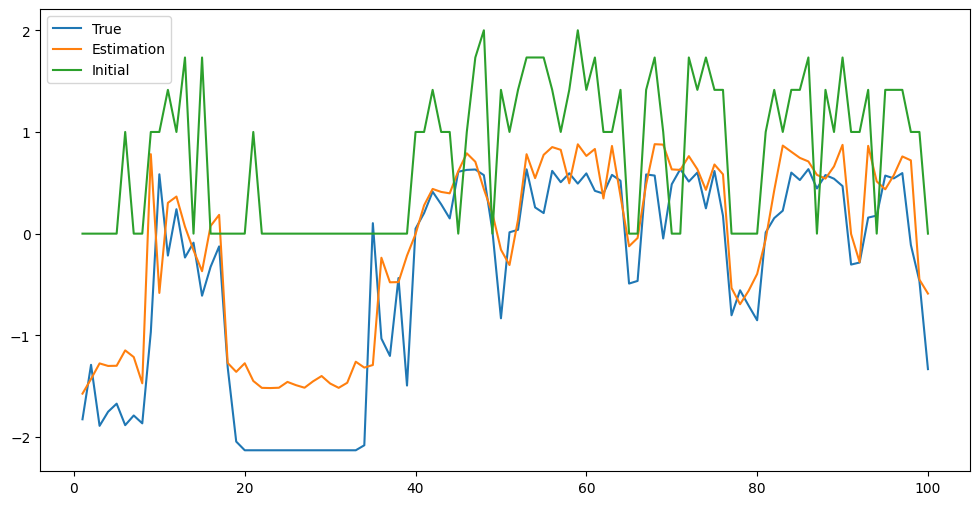

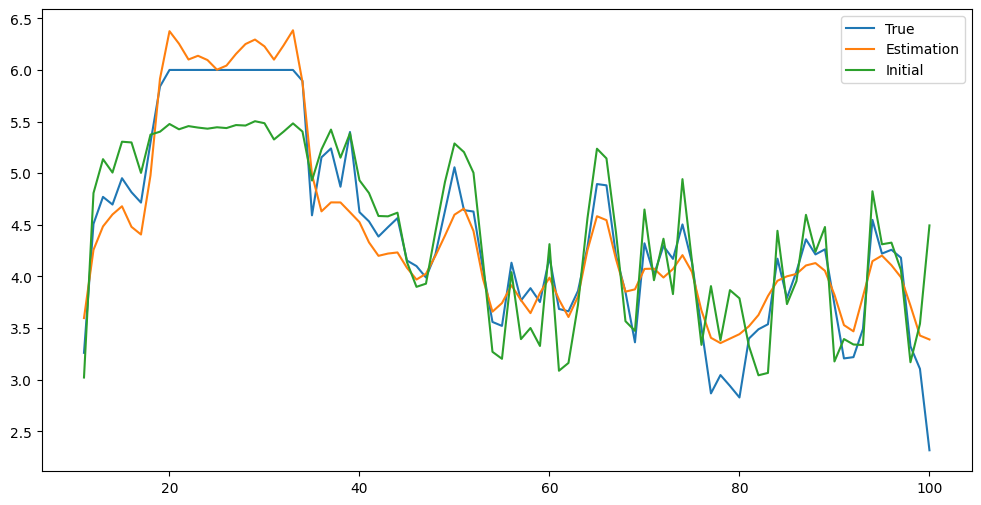

In [ ]:
# plot the results
i=1     # choose the neuron to plot
plot_log_fr_estimation(time, f_truth[i:i+1,:], f_static[i:i+1,:], fr0 = f_initial[i:i+1,:])
# plot_hidden_estimation(time, X_truth, affine_to(X_truth, X_est), hidden_0=affine_to(X_truth, X_ppca), x_lim = None, y_lim = None)

# avoid the first 10 time points
plot_hidden_estimation(time[10:], X_truth[:,10:], affine_to(X_truth[:,10:], X_est[:,10:]), hidden_0=affine_to(X_truth[:,10:], X_ppca[:,10:]), x_lim = None, y_lim = None)

From the result, we can see that $f$ estimation is close to the true value but $X$ estimation (affined to the ground truth) is not that close. 

## 3. Discussion

### 3.1. Singular $K_x$ and decaying noise variance $\sigma^2$ trick

In most cases, $K_x$ is going to be singular. 
#### Code showing this result:

In [ ]:
l2s = 10 ** np.linspace(-3,3,30)
non_invs = []
for l2 in l2s:
    ml = ML_l2(f_truth, l20 = l2, time_index = X_truth, sigma2 = 1).double()        # using the true X values
    non_inv, _, _, _, _,_,_= ml()
    non_invs.append(non_inv)
print(non_invs)

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [ ]:
l2s = 10 ** np.linspace(-3,3,30)
non_invs = []
for l2 in l2s:
    ml = ML_l2(f_truth, l20 = l2, time_index = X_ppca, sigma2 = 1).double()     # using the PPCA initial X values
    non_inv, _, _, _, _,_,_= ml()
    non_invs.append(non_inv)
print(non_invs)

[0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


The results show that $K_x$ is nearly always singular.

In the author's implementation, they add a diagonal $K_x+\sigma^2 I$ to help with the inversion. However, this is not shown in the paper. I knew this from the author by email. The author told me that, $\sigma^2$ is the noise variance that decay as the iteration goes. It is a very common trick for GP models. Sometimes people explicitly write it out in the paper (Like in a previous work *Variational inference for uncertainty on the inputs of gaussian process models*), sometimes people don’t (Like in this paper).

And for the rationality of adding a noise variance, the author further claimed that it is a reasonable modeling choice for gaussian observation because you the continuous observation can be assumed to be GP+gaussian noise. For poisson, it is also feasible to assume the same way, i.e., the fundamental firing rate is a gaussian corrupted version of GP functions. But since in this paper we already have a poisson observation model, we don’t assume the gaussian noise to be very large. That’s why the $\sigma^2$ is set to decay as the optimization goes.

When I implement $K_x(X)$ part, I didn't know that I should $+\sigma^2 I$, so I developed an equivalent formula that doesn't require the inverse. But even though it can $+\sigma^2 I$, my method still should have some advantagement, because it's the same as using better estimated $K_x$ at first several iterations when $\sigma^2$ is still large.



### 3.2. Renew of $l$ and $\rho$

$l$ and $\rho$ are renewed by Maximum Likelihood. Take $l_{xt}$ and $\rho_{xt}$ as an example:

$$\begin{align*}
    \log L(l_{xt}, \rho_{xt}) = \log p(X|l_{xt}, \rho_{xt}) &= - {1 \over 2} X^T K_t^{-1}X -{1 \over 2} \log |K_t|\\
    &= - {1 \over 2  \rho_{xt}} X^T K_t^{-1}|_{ \rho_{xt}=1} X -{1 \over 2} \log |K_t||_{ \rho_{xt}=1} -{T \over 2} \log \rho_{xt}
\end{align*}$$

which means we can regard $\rho_{xt}$ as a coefficient of $- {1 \over 2} X^T K_t^{-1}X $ term and keeps $\rho_{xt}=1$ for calculating $K_t$ when optimizing $l_{xt}$. After getting $l_{xt}^*$, renew $\rho_{xt}$ by 
$$ \rho_{xt}^* \leftarrow {1 \over T} X^T K_t^{-1}|_{ \rho_{xt}=1, l_{xt}^*} X 
$$

### 3.3. Performance and Time Comsumption

As said in the 1.2, my results are not as good as the author's, possibly due to less effective optimization in my implementation. So, my algorithm is slower and doesn't converge.

The author's original code is much more faster than mine, and it will converge within half minute. I guess there are reasons like:

1. In MATLAB, the author take gradient by hand and use minimizer to optimize the MAP. But I use torch.nn for automatic gradient, which will be slower than minimizer.

2. I call a MAP class and 2 ML classes in each iteration, calling constructor and destructor will waste a lot of time.